Use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

### Importing packages

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import torch
from torch import nn

In [4]:
import torch
print('PyTorch version:', torch.__version__)
if torch.cuda.is_available():
  print("You have %d GPUs" % torch.cuda.device_count())
  gpu_id = torch.cuda.current_device()
  print("The selected GPU is GPU", gpu_id)
  print("- Name:", torch.cuda.get_device_name(gpu_id))
  print("- All properties:",torch.cuda.get_device_properties(gpu_id))

PyTorch version: 2.0.0
You have 1 GPUs
The selected GPU is GPU 0
- Name: NVIDIA GeForce RTX 3080 Ti
- All properties: _CudaDeviceProperties(name='NVIDIA GeForce RTX 3080 Ti', major=8, minor=6, total_memory=12287MB, multi_processor_count=80)


### Data loading and preprocessing

In [29]:
column_names = ['PassengerId','Survived','TicketClass','Name','Sex','Age','SiblingsSpouses','ParentChildren','TicketNumber','Fare','Cabin','Embarked']
raw_data_train = pd.read_csv('train.csv', header=0, names=column_names, delimiter=",", skipinitialspace=True) #header=0 + names allows to override headers

column_names = ['PassengerId','TicketClass','Name','Sex','Age','SiblingsSpouses','ParentChildren','TicketNumber','Fare','Cabin','Embarked']
raw_data_test = pd.read_csv('train.csv', header=0, names=column_names, delimiter=",", skipinitialspace=True) #header=0 + names allows to override headers

raw_data_train.tail()

,PassengerId,Survived,TicketClass,Name,Sex,Age,SiblingsSpouses,ParentChildren,TicketNumber,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


Now we'll analyze the data in the training set:

In [25]:
raw_data_train.isna().sum()/len(raw_data_train)

PassengerId        0.000000
Survived           0.000000
TicketClass        0.000000
Name               0.000000
Sex                0.000000
Age                0.198653
SiblingsSpouses    0.000000
ParentChildren     0.000000
TicketNumber       0.000000
Fare               0.000000
Cabin              0.771044
Embarked           0.002245
dtype: float64

In [ ]:
sns.pairplot(raw_data_train[["Survived", "TicketClass", "Sex", "SiblingsSpouses", "ParentChildren", "Fare", "Cabin", "Embarked"]], diag_kind="hist")
plt.show()

After inspecting the dataset, the following considerations can be made:
- PassengerId and TicketNumer are apparently useless features for the task so we'll drop them
- The cabin attribute is unknown for 77% of the samples, so we'll drop the feature
- We'll drop the two samples without embarkment informations
- Even if for almost 20% of the dataset the age is unknown, it is probably an important feature, so we'll drop the samples without age info for semplicity
- We must use One-Hot Encoding for the categorical features 'TicketClass', 'Sex' and 'Embarked'
- We can extract useful information about the social status of the person from the Name attribute

We define a function to preprocess raw data. It will be used to preprocess both the training set and later the test set:

In [55]:
def preprocess_raw_data(raw_data: pd.DataFrame):
  data = raw_data.copy()
  #Drop unnecessary features
  data = data.drop(['PassengerId','TicketNumber','Cabin'],axis=1)
  #Drop samples without age or without embarkment info
  data = data.dropna()
  #One-Hot encode categorical features
  sex = data.pop('Sex')
  data['Male'] = (sex == 'male') * 1.0
  data['Female'] = (sex == 'female') * 1.0
  tClass = data.pop('TicketClass')
  data['UpperClass'] = (tClass == 1) * 1.0
  data['MiddleClass'] = (tClass == 2) * 1.0
  data['LowerClass'] = (tClass == 3) * 1.0
  embarked = data.pop('Embarked')
  data['CherbourgPort'] = (embarked == 'C') * 1.0
  data['QueenstownPort'] = (embarked == 'Q') * 1.0
  data['SouthamptonPort'] = (embarked == 'S') * 1.0
  #Extract the title from the name
  titles = data.pop('Name').str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
  data['Mr'] = (titles == 'Mr') * 1.0
  data['Miss/Mrs/Ms/Lady'] = ((titles == 'Miss') | (titles == 'Mrs') | (titles == 'Ms') | (titles == 'Lady') | (titles == 'Mme') | (titles == 'Mlle')) * 1.0
  data['Master'] = (titles == 'Master') * 1.0
  data['Rev/Dr/Major/Col/Contess/Capt/Sir/Don/Jonkheer'] = ((titles == 'Rev') | (titles == 'Dr') | (titles == 'Major') | (titles == 'Col') | (titles == 'the Countess') | (titles == 'Capt') | (titles == 'Sir') | (titles == 'Don') | (titles == 'Jonkheer') ) * 1.0
  return data

train_data = preprocess_raw_data(raw_data_train)
train_data.tail()
train_data.sum()


['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']


Survived                                            288.000
Age                                               21105.170
SiblingsSpouses                                     366.000
ParentChildren                                      308.000
Fare                                              24611.883
Male                                                453.000
Female                                              259.000
UpperClass                                          184.000
MiddleClass                                         173.000
LowerClass                                          355.000
CherbourgPort                                       130.000
QueenstownPort                                       28.000
SouthamptonPort                                     554.000
Mr                                                  398.000
Miss/Mrs/Ms/Lady                                    257.000
Master                                               36.000
Rev/Dr/Major/Col/Contess/Capt/Sir/Don/Jo

KeyboardInterrupt: 

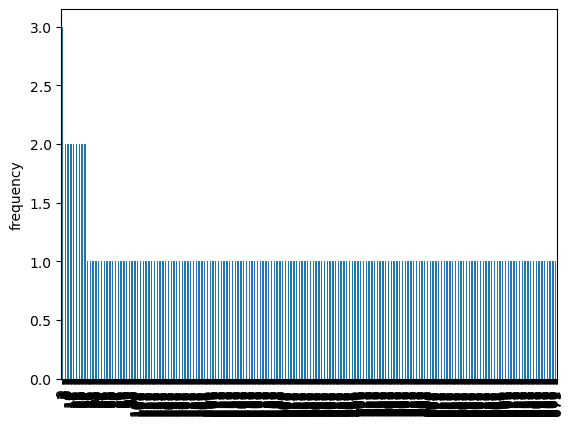